# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=1000

global T
global target
T=20
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):
    vecs_new=[]
    u=action[0]
    v=action[1]
    diff=Z(vecs,u,v)
    for i in range(num_system):
        w=vecs[i]+delta_t*diff[i]
        '''
        if w[2]>np.pi:
            w[2]-=2*np.pi
        if w[2]<-np.pi:
            w[2]+=2*np.pi
        '''
        vecs_new.append(w)
    return np.array(vecs_new)

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return -(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4]

# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        return(np.random.randint(6)), True
    else:
        return(find_max(cand)), False
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [5]:
num_iter=50

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k, _ = decide_u(observation,candidates_u,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            for i in range(6):
                cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
            #print(candidates_u)
            u_k, explo = decide_u(observation,np.array(candidates_u))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
            
            
            if abs(r)<0.03:
                break
            

    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1))
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.81it/s]

observation = [-2.81897300e+00 -2.01132381e+00  1.72787596e-01  8.34208253e-04
  6.39660317e-07]


  4%|███▎                                                                               | 2/50 [00:02<01:23,  1.74s/it]

observation = [ 5.22951282 -4.71215228 -1.35088484  0.22603517  0.27722512]


  6%|████▉                                                                              | 3/50 [00:06<02:02,  2.61s/it]

observation = [-6.86691004 -6.01904663  1.88495559  0.27828388  0.20130394]


  8%|██████▋                                                                            | 4/50 [00:11<02:46,  3.62s/it]

observation = [ 6.52911018e-01 -2.20912624e+00 -3.14159265e-02  8.19168058e-03
  2.09098786e-04]


 10%|████████▎                                                                          | 5/50 [01:09<17:12, 22.95s/it]

observation = [ 5.05204267e-01 -1.13893165e+00 -1.49225651e+00  1.89034649e-02
  1.35409168e-03]


 12%|█████████▉                                                                         | 6/50 [01:17<13:07, 17.89s/it]

observation = [-2.8577861   2.94874917 -1.11526539  0.03636831  0.06170943]


 14%|███████████▌                                                                       | 7/50 [01:56<17:49, 24.87s/it]

observation = [ 1.50014958e+00 -2.62027307e+00 -2.19911486e-01  1.46153319e-02
  1.93019210e-03]


 16%|█████████████▎                                                                     | 8/50 [02:33<20:14, 28.93s/it]

observation = [ 1.61916427 -1.1762109   2.81172542  0.0033004   0.00670086]


 18%|██████████████▉                                                                    | 9/50 [02:48<16:41, 24.44s/it]

observation = [-3.15473776e+00 -9.12121186e-01  1.30376095e+00  1.51712102e-03
  6.09499621e-02]


 20%|████████████████▍                                                                 | 10/50 [04:08<27:44, 41.62s/it]

observation = [ 4.30040253e+00 -2.50079795e+00 -1.57079633e-01  4.71834402e-02
  1.20532100e-03]


 22%|██████████████████                                                                | 11/50 [04:52<27:31, 42.34s/it]

observation = [ 1.91070309 -3.68668449 -0.4712389   0.01293881  0.01353377]


 24%|███████████████████▋                                                              | 12/50 [05:47<29:09, 46.03s/it]

observation = [ 0.08578674  1.10050551 -1.08384947  0.03635055  0.02583592]


 26%|█████████████████████▎                                                            | 13/50 [07:36<40:11, 65.16s/it]

observation = [-1.4517662  -0.58048988 -2.40331838  0.01002754  0.00910657]


 28%|██████████████████████▉                                                           | 14/50 [08:28<36:42, 61.19s/it]

observation = [-1.92349058e-01 -1.47827634e+00 -7.53982237e-01  7.15941696e-03
  9.91357394e-04]


 30%|████████████████████████▌                                                         | 15/50 [09:58<40:46, 69.91s/it]

observation = [-2.54963680e-02 -2.34833723e+00 -6.12610567e-01  5.48181108e-03
  7.92115972e-04]


 32%|██████████████████████████▏                                                       | 16/50 [11:28<43:07, 76.11s/it]

observation = [ 1.59688483e+00 -2.55910162e+00 -2.98451302e-01  1.57273564e-02
  1.59899817e-03]


 34%|███████████████████████████▉                                                      | 17/50 [13:04<45:09, 82.12s/it]

observation = [ 1.13258546e+00 -2.34067575e+00 -4.08407045e-01  1.44753933e-02
  8.38474609e-04]


 36%|█████████████████████████████▌                                                    | 18/50 [14:47<46:59, 88.12s/it]

observation = [ 3.36922253e-01 -1.92120634e+00 -5.81194641e-01  9.64793338e-03
  1.54301109e-07]


 38%|██████████████████████████████▊                                                  | 19/50 [17:08<53:51, 104.24s/it]

observation = [ 1.36127406e+00 -2.51106158e+00 -3.29867229e-01  1.49418141e-02
  1.54899061e-03]


 40%|████████████████████████████████▍                                                | 20/50 [18:42<50:35, 101.20s/it]

observation = [ 2.18609801 -0.33397638  2.49756616  0.00594973  0.00438436]


 42%|██████████████████████████████████                                               | 21/50 [20:57<53:41, 111.10s/it]

observation = [ 5.88477264 -0.82344809  0.50265482  0.06256049  0.00626131]


 44%|███████████████████████████████████▋                                             | 22/50 [23:17<55:54, 119.81s/it]

observation = [ 3.52848819e+00 -1.70948103e+00  1.41371669e-01  2.62399735e-02
  2.84923959e-04]


 46%|█████████████████████████████████████▋                                            | 23/50 [23:39<40:43, 90.49s/it]

observation = [ 2.03896181e+00 -2.22128214e+00 -2.35619449e-01  1.91893677e-02
  2.38461277e-04]


 48%|███████████████████████████████████████▎                                          | 24/50 [24:04<30:41, 70.85s/it]

observation = [ 3.2195489  -0.16633672  0.09424778  0.01994138  0.0142943 ]


 50%|█████████████████████████████████████████                                         | 25/50 [24:41<25:20, 60.82s/it]

observation = [3.35060655e+00 1.47736750e+00 3.14159265e-01 3.01788855e-03
 3.47832743e-02]


 52%|██████████████████████████████████████████▋                                       | 26/50 [25:33<23:13, 58.08s/it]

observation = [ 3.6854825  -0.19003471  1.79070781  0.0256091   0.02210389]


 54%|████████████████████████████████████████████▎                                     | 27/50 [26:09<19:44, 51.52s/it]

observation = [2.54853363e+00 2.05636960e+00 1.57079633e+00 1.56227182e-03
 1.69965335e-02]


 56%|█████████████████████████████████████████████▉                                    | 28/50 [26:40<16:36, 45.29s/it]

observation = [3.43473206e+00 1.31851958e+00 4.71238898e-01 3.42841759e-03
 3.01714988e-02]


 58%|███████████████████████████████████████████████▌                                  | 29/50 [27:14<14:42, 42.00s/it]

observation = [ 2.47018245e+00  2.61570217e+00 -2.62322987e+00  2.13889994e-03
  1.45905017e-03]


 60%|█████████████████████████████████████████████████▏                                | 30/50 [28:07<15:04, 45.24s/it]

observation = [ 4.45056653e+00 -1.17260962e+00  3.92699082e-01  4.56544238e-02
  3.14553697e-03]


 62%|██████████████████████████████████████████████████▊                               | 31/50 [28:51<14:09, 44.71s/it]

observation = [-3.1127892   4.39459114  0.06283185  0.04696059  0.11815726]


 64%|████████████████████████████████████████████████████▍                             | 32/50 [29:33<13:10, 43.93s/it]

observation = [ 2.78830683e+00 -2.42560351e+00 -4.71238898e-02  2.69906215e-02
  8.73624445e-04]


 66%|██████████████████████████████████████████████████████                            | 33/50 [30:21<12:49, 45.24s/it]

observation = [ 1.66818113  0.25165308 -1.77499985  0.02693371  0.01936986]


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [31:10<12:23, 46.47s/it]

observation = [ 2.59454167e+00 -2.28149507e+00 -9.42477796e-02  2.58102120e-02
  3.90853235e-04]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [32:32<14:17, 57.14s/it]

observation = [ 3.96768072e-01 -2.09294618e+00 -5.65486678e-01  9.20004180e-03
  1.37215128e-04]


 72%|███████████████████████████████████████████████████████████                       | 36/50 [34:28<17:26, 74.74s/it]

observation = [4.65808877 0.08551391 1.11526539 0.03452681 0.01739278]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [36:37<19:43, 91.01s/it]

observation = [4.96925689 1.29811274 1.63362818 0.01757877 0.03531805]


 76%|█████████████████████████████████████████████████████████████▌                   | 38/50 [38:59<21:15, 106.29s/it]

observation = [ 3.26267299e+00 -2.01428391e+00  6.28318531e-02  3.36556122e-02
  6.37794469e-07]


 78%|███████████████████████████████████████████████████████████████▏                 | 39/50 [41:24<21:35, 117.74s/it]

observation = [ 5.43905718e+00 -1.15723890e+00  6.91150384e-01  5.36148023e-02
  2.87516883e-03]


 80%|████████████████████████████████████████████████████████████████▊                | 40/50 [44:08<21:57, 131.72s/it]

observation = [2.93687687e+00 2.19299068e+00 2.81172542e+00 1.21199894e-03
 1.41911559e-02]


 82%|██████████████████████████████████████████████████████████████████▍              | 41/50 [47:29<22:53, 152.63s/it]

observation = [ 4.35694647e+00 -1.12402393e+00  3.92699082e-01  7.47068544e-02
  1.90983638e-04]


 84%|████████████████████████████████████████████████████████████████████             | 42/50 [50:53<22:22, 167.87s/it]

observation = [ 2.90127372e+00 -2.41159721e+00 -1.57079633e-02  2.90837393e-02
  8.49510340e-04]


 86%|█████████████████████████████████████████████████████████████████████▋           | 43/50 [54:06<20:28, 175.45s/it]

observation = [ 3.00486555e+00 -1.65141478e+00 -3.14159265e-02  3.09354117e-02
  6.04218843e-04]


 88%|███████████████████████████████████████████████████████████████████████▎         | 44/50 [58:13<19:41, 196.92s/it]

observation = [ 2.18816804e+00 -1.36165124e+00 -1.57079633e-01  2.12785570e-02
  1.97668845e-03]


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [1:02:29<17:53, 214.74s/it]

observation = [4.89495894 0.04881144 0.80110613 0.04004603 0.01817788]


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [1:07:10<15:38, 234.59s/it]

observation = [ 2.05610880e+00 -2.58262136e+00 -2.04203522e-01  1.96848179e-02
  1.68818410e-03]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [1:11:57<12:30, 250.18s/it]

observation = [ 2.54803919 -1.09658118 -0.18849556  0.02257734  0.00387606]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [1:17:40<09:16, 278.04s/it]

observation = [ 1.24020256  0.69369208 -1.49225651  0.02835647  0.02506315]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [1:23:55<05:07, 307.23s/it]

observation = [2.86379593 0.52624238 0.03141593 0.04534554 0.01910324]


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:28:06<00:00, 105.74s/it]

observation = [ 2.88131905e+00 -2.32754337e+00 -3.14159265e-02  2.83838960e-02
  5.23409845e-04]


# Results

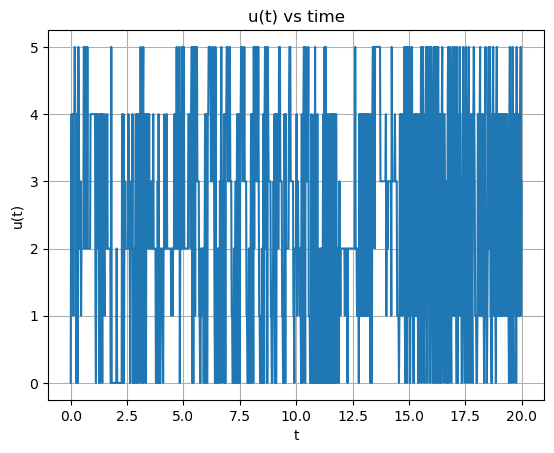

In [6]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


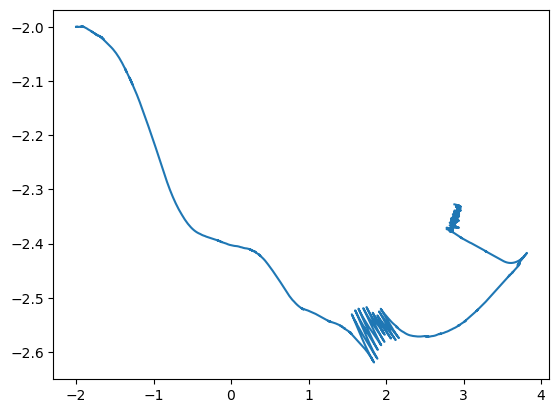

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

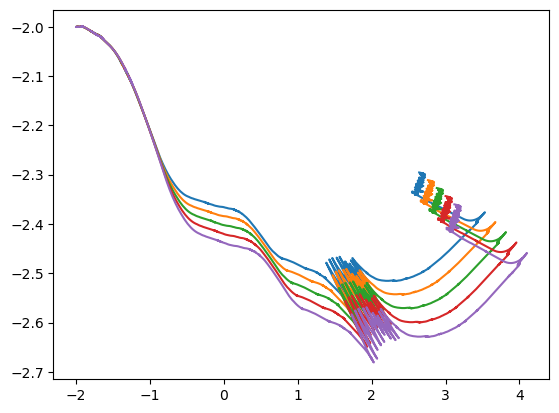

In [8]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Best Trajectory

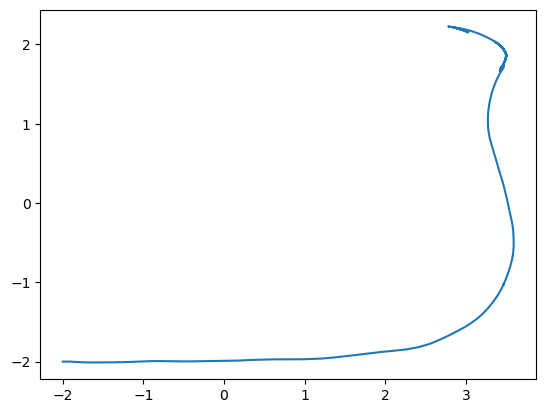

In [9]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

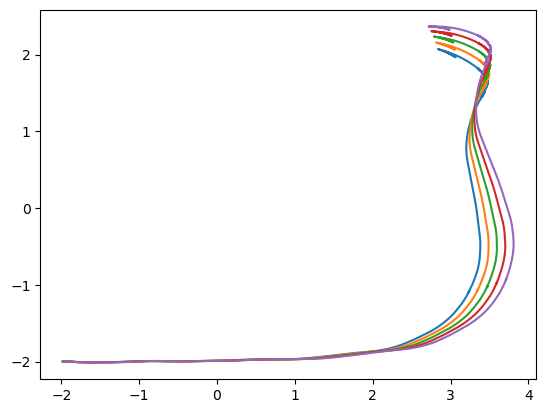

In [10]:
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Pure Exploitation Trajectory

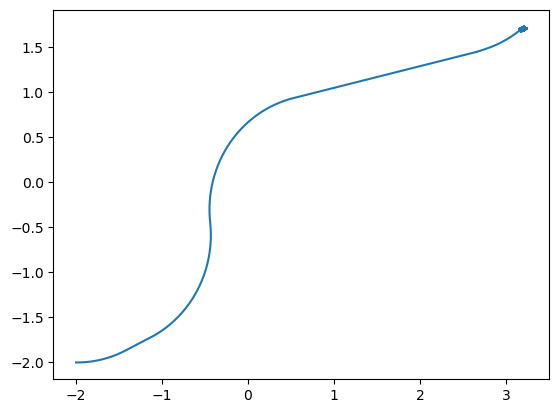

In [11]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

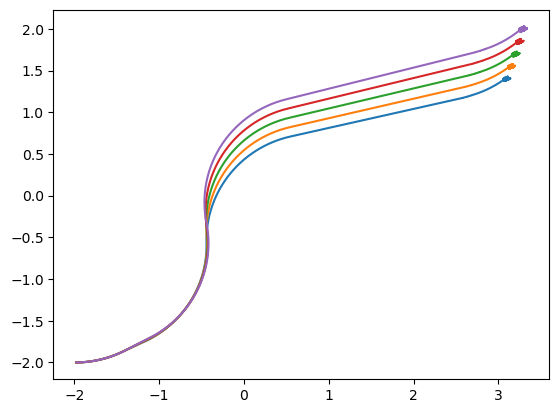

In [12]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

In [13]:
print(observation_t[-1])

[3.19347768 1.71917716 0.39269908 0.00450738 0.04500799]
